# How does low-dimensional analyzers work?

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_advanced/advanced_lowdim_analysis.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_advanced/advanced_lowdim_analysis.ipynb)

@[Chaoming Wang](https://github.com/chaoming0625)

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. BrainPy has well supports for low-dimensional systems, no matter how nonlinear your defined system is. Specifically, BrainPy provides the following methods for the analysis of low-dimensional systems:

1. phase plane analysis;
2. codimension 1 or codimension 2 bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 

BrainPy will help you probe the dynamical mechanism of your defined systems rapidly. 

In [11]:
import brainpy.version2 as bp
import brainpy.version2.math as bm

# bp.math.set_platform('cpu')
bp.math.enable_x64()  # It's better to enable x64 when performing analysis

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In this section, we provide a basic tutorial to understand how the ``brainpy.analysis.LowDimAnalyzer`` works.

## Terminology

Given the FitzHugh-Nagumo model, we define an analyzer,

In [13]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(1))
    self.w = bm.Variable(bm.zeros(1))
    self.Iext = bm.Variable(bm.zeros(1))

    # functions
    def dV(V, t, w, Iext=0.):
        return V - V * V * V / 3 - w + Iext
    def dw(w, t, V, a=0.7, b=0.8):
        return (V + a - b * w) / self.tau
    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, tdi):
    self.V.value = self.int_V(self.V, tdi.t, self.w, self.Iext, tdi.dt)
    self.w.value = self.int_w(self.w, tdi.t, self.V, self.a, self.b, tdi.dt)
    self.Iext[:] = 0.

In [14]:
model = FitzHughNagumoModel()

In [15]:
analyzer = bp.analysis.PhasePlane2D(
  [model.int_V, model.int_w],
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  resolutions={'V': 0.01, 'w': 0.01},
)

In this instance of ``brainpy.analysis.LowDimAnalyzer``, we use the following terminologies.

- **x_var** and **y_var** are defined by the order of the user setting. If the user sets the "target_vars" as "{'V': ..., 'w': ...}",  ``x_var`` and ``y_var`` will be "V" and "w" respectively. Otherwise, if "target_vars"="{'w': ..., 'V': ...}", ``x_var`` and ``y_var`` will be "w" and "V" respectively.

In [16]:
analyzer.x_var, analyzer.y_var

('V', 'w')

- **fx** and **fy** are defined as differential equations of ``x_var`` and ``y_var`` respectively, i.e.,

``fx`` is

```python
def dV(V, t, w, Iext=0.):
    return V - V * V * V / 3 - w + Iext
```

``fy`` is

```
def dw(w, t, V, a=0.7, b=0.8):
    return (V + a - b * w) / self.tau
```

In [17]:
analyzer.F_fx, analyzer.F_fy

(<PjitFunction of <function remove_return_shape.<locals>.f2 at 0x0000026E3A524D60>>,
 <PjitFunction of <function remove_return_shape.<locals>.f2 at 0x0000026E3A525080>>)

- **int_x** and **int_y** are defined as integral functions of the differential equations for ``x_var`` and ``y_var`` respectively.

In [18]:
analyzer.F_int_x, analyzer.F_int_y

(functools.partial(<function std_derivative.<locals>.inner.<locals>.call at 0x0000026E3A524AE0>),
 functools.partial(<function std_derivative.<locals>.inner.<locals>.call at 0x0000026E3A524B80>))

- **x_by_y_in_fx** and **y_by_x_in_fx**: They denote that ``x_var`` and ``y_var`` can be separated from each other in "fx" nullcline function. Specifically, ``x_by_y_in_fx`` or ``y_by_x_in_fx`` denotes $x = F(y)$ or $y = F(x)$ accoording to $f_x=0$ equation. For example, in the above FitzHugh-Nagumo model, $w$ can be easily represented by $V$ when $\mathrm{dV(V, t, w, I_{ext})} = 0$, i.e., ``y_by_x_in_fx`` is $w= V - V ^3  / 3 + I_{ext}$.


- Similarly, **x_by_y_in_fy** ($x=F(y)$) and **y_by_x_in_fy** ($y=F(x)$) denote ``x_var`` and ``y_var`` can be separated from each other in "fy" nullcline function. For example, in the above FitzHugh-Nagumo model, ``y_by_x_in_fy`` is $w= \frac{V + a}{b}$, and ``x_by_y_in_fy`` is $V= b * w - a$.

- ``x_by_y_in_fx``, ``y_by_x_in_fx``, ``x_by_y_in_fy`` and ``y_by_x_in_fy`` can be set in the ``options`` argument.

## Mechanism for 1D system analysis

In order to understand the adavantages and disadvantages of BrainPy's analysis toolkit, it is better to know the minimal mechanism how ``brainpy.analysis`` works.

The automatic model analysis in BrainPy heavily relies on numerical optimization methods, including [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method) and [BFGS method](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). For example, for the above one-dimensional system ($\frac{dx}{dt} = \mathrm{sin}(x) + I$), after the user sets the resolution to ``0.001``, we will get the evaluation points according to the variable boundary ``[-10, 10]``.

In [19]:
bp.math.arange(-10, 10, 0.001)

Array(value=Array([-10.   ,  -9.999,  -9.998, ...,   9.997,   9.998,   9.999],      dtype=float64), dtype=float64)

Then, BrainPy filters out the candidate intervals in which the roots lie in. Specifically, it tries to find all intervals like $[x_1, x_2]$ where $f(x_1) * f(x_2) \le 0$ for the 1D system $\frac{dx}{dt} = f(x)$.

For example, the following two points which have opposite signs are candidate points we want.

In [20]:
def plot_interval(x0, x1, f):
    xs = np.linspace(x0, x1, 100)
    plt.plot(xs, f(xs))
    plt.scatter([x0, x1], f(np.asarray([x0, x1])), edgecolors='r')
    plt.axhline(0)
    plt.show()

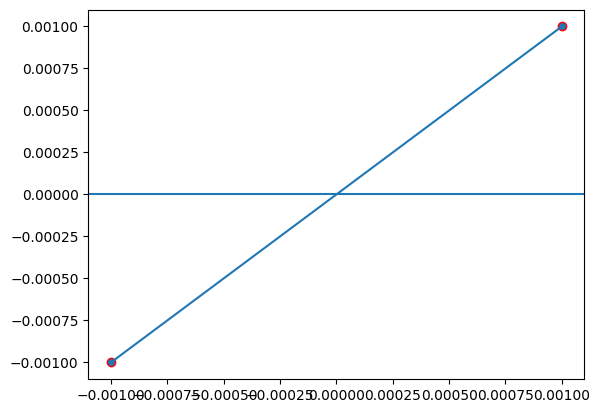

In [21]:
plot_interval(-0.001, 0.001, lambda x: np.sin(x))

According to the intermediate value theorem, there must be a solution between $x_1$ and $x_2$ when $f(x_1) * f(x_2) \le 0$.

Based on these candidate intervals, BrainPy uses Brent's method to find roots $f(x) = 0$. Further, after obtain the value of the root, BrainPy uses automatic differentiation to evaluate the stability of each root solution.

Overall, BrainPy's analysis toolkit shows significant advantages and disadvantages.

**Pros**: BrainPy uses numerical methods to find roots and evaluate their stabilities, it does not case about how complex your function is. Therefore, it can apply to general problems, including any 1D and 2D dynamical systems, and some part of low-dimensional ($\ge 3$) dynamical systems (see later sections). Especially, BrainPy's analysis toolkit is highly useful when the mathematical equations are too complex to get analytical solutions (the example please refer to the tutorial [Anlysis of A Decision Making Model](./decision_making_model.ipynb)).

**Cons**: However, numerical methods used in BrainPy are hard to find fixed points only exist at a moment. Moreover, when ``resolution`` is small, there will be large amount of calculating. Users should pay attention to designing suitable resolution settings.

## Mechanism for 2D system analysis

**plot_vector_field()**

Plotting vector field is simple. We just need to evaluate the values of each differential equation.

**plot_nullcline()**

Nullclines are evaluated through the Brent's methods. In order to get all $(x, y)$ values that satisfy ``fx=0`` (i.e., $f_x(x, y) = 0$), we first fix $y=y_0$, then apply Brent optimization to get all $x'$ that satisfy $f_x(x', y_0) = 0$ (alternatively, we can fix $x$ then optimize $y$). Therefore, we will perform Brent optimization many times, because we will iterate over all $y$ value according to the resolution setting.

**plot_fixed_points()**

The fixed point finding in BrainPy relies on BFGS method. First, we define an auxiliary function $L(x, t)$:

$$
L(x, y) = f_x^2(x, y) + f_y^2(x, y).
$$

$L(x, t)$ is always bigger than 0. We use BFGS optimization to get all local minima. Finally, we filter out the minima whose losses are smaller than $1e^{-8}$, and we choose them as fixed points.

For this method, how to choose the initial points to perform optimization is the challege, especially when the parameter resolutions are small. Generally, there are four methods provided in BrainPy.

- **fx-nullcline**: Choose the points in "fx" nullcline as the initial points for optimization.
- **fy-nullcline**: Choose the points in "fy" nullcline as the initial points for optimization.
- **nullclines**: Choose both the points in "fx" nullcline and "fy" nullcline as the initial points for optimization.
- **aux_rank**: For a given set of parameters, we evaluate loss function at each point according to the resolution setting. Then we choose the first ``num_rank`` (default is 100)  points which have the smallest losses.

However, if users provide one of functions of ``x_by_y_in_fx``, ``y_by_x_in_fx``, ``x_by_y_in_fy`` and ``y_by_x_in_fy``. Things will become very simple, because we can change the 2D system as a 1D system, then we only need to optimzie the fixed points by using our favoriate Brent optimization.

For the given FitzHugh-Nagumo model, we can set

I am making bifurcation analysis ...
I am trying to find fixed points by brentq optimization ...
I am trying to filter out duplicate fixed points ...
	Found 5000 fixed points.


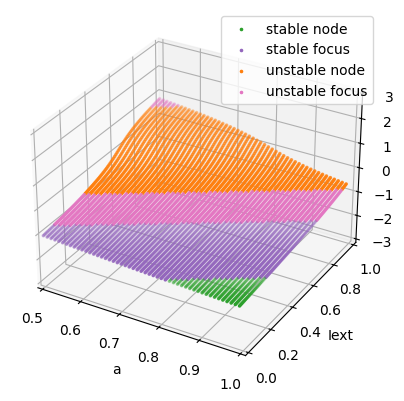

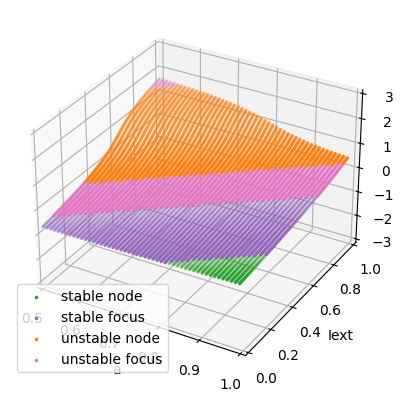

In [22]:
analyzer = bp.analysis.Bifurcation2D(
    model,
    target_vars=dict(V=[-3, 3], w=[-3., 3.]),
    target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
    resolutions={'a': 0.01, 'Iext': 0.01},
    options={bp.analysis.C.y_by_x_in_fy: (lambda V, a=0.7, b=0.8: (V + a) / b)}
)
analyzer.plot_bifurcation()
analyzer.show_figure()

## References

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.
